### Bayesian Data Analysis, 3rd ed
##  Chapter 3, demo 6

원저자:

- Aki Vehtari aki.vehtari@aalto.fi
- Tuomas Sivula tuomas.sivula@aalto.fi

2차저자:

- 문현지, 민태규

Bioassay data로 사후분포 추정 (BDA3 p. 74-).

#### 연습지침 (3.11 in BDA3)
- 여러 사전분포에 대해 A와 B의 범위와 간격이 적절한지 확인
- grid에서 로그사후분포 계산
- 로그사후분포의 scaling: 로그사후분포를 지수승(exponentiating)하기 전 자신의 최댓값을 빼기 (의미있는 이유 생각해보기)
- 지수승
- 사후분포 정규화
- 2D grid 이용하기
- plot외에 p(beta>0|x,y) 계산해볼기

In [32]:
import numpy as np
from scipy.special import expit  # aka logistic
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
import plot_tools
plt.rc('font', size=12)
plt.style.use(plot_tools.custom_styles['gray_background'])

In [33]:
# 랜덤시드 설정
rng = np.random.RandomState(0)

In [34]:
# 데이터
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

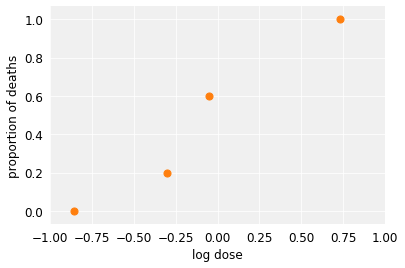

In [35]:
# 데이터 plot
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

In [36]:
# 사후분포밀도를 grid에서 계산
# - 일반적으로 log형태로 계산
# - 여러 사전분포를 실험해볼 경우 A, B의 범위와 간격이 적절한지 반드시 확인
A = np.linspace(-4, 8, 100)
B = np.linspace(-10, 40, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

다음은 for문을 이용한 p 사후분포 계산의 안좋은 예시다. 벡터화된 위 방식이 더 효율적이다. 물론 현재는 계산량이 많지 않아 큰 차이가 없다.

```python
p = np.empty((len(B),len(A))) # allocate space
for i in range(len(A)):
    for j in range(len(B)):
        ilogit_abx_ij = (1 / (np.exp(-(A[i] + B[j] * x)) + 1))
        p[j,i] = np.prod(ilogit_abx_ij**y * ilogit_abx_ij**(n - y))
```
메모리를 최적화하는 in-place statements이용시 더 효율적인 벡터표현이 가능하나 여기선 생략한다.

In [37]:
# grid에서 샘플링
nsamp = 1000
samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]

# 샘플링된 결과가 연속분포가 되도록 0평균의 random jitter를 더한다(p.76)
samp_A += (rng.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (rng.rand(nsamp) - 0.5) * (B[1]-B[0])

# beta > 0라는 조건을 걸었을 때 LD50(= −α/β)의 샘플 
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi] / samp_B[bpi]

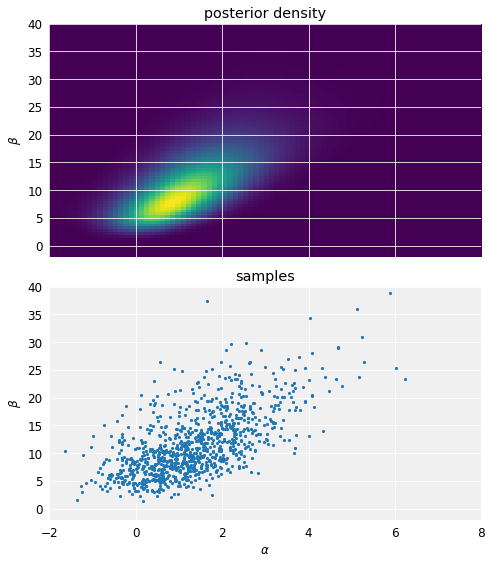

In [56]:
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# 사후분포밀도함수 plot
ax = axes[0]
ax.imshow(p, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# 샘플들을 plot
ax = axes[1]
ax.scatter(samp_A, samp_B, 10, linewidth=0)
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

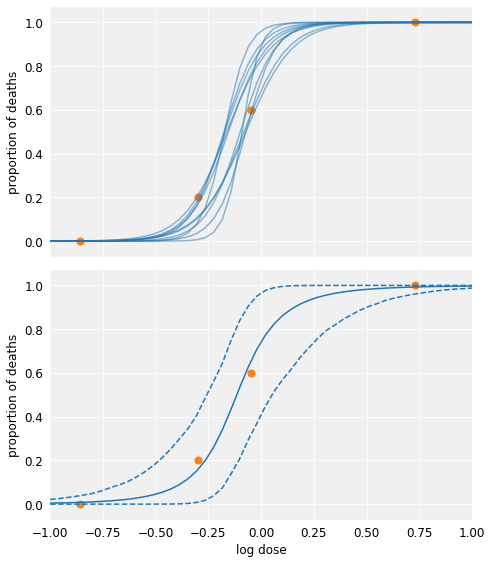

In [61]:
# 데이터와 샘플을 함께 plot
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt) # expit: logit function의 역함수

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# 첫 10개 샘플 plot
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# 샘플들의 평균과 [5% 95%] 구간
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

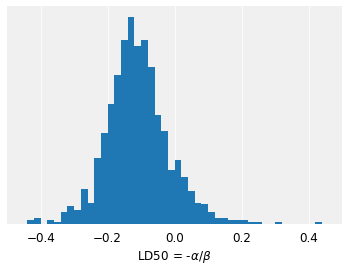

In [62]:
# LD50의 히스토그램 plot
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());